In [ ]:
import torch
from torch.autograd import Variable

In [ ]:
a = torch.randn((64,241,101))

In [ ]:
a.shape

In [ ]:
a[:,:,:,0].shape

In [ ]:
z_hat = torch.randn((64,101,40))
z_hat = Variable(z_hat,requires_grad=True)
z_hat

In [ ]:
delta = z_hat - a
delta.shape

In [ ]:
rho = torch.mean((torch.norm(delta.view(len(a),-1),2,1)**2)) 
rho

In [ ]:
delta.view(len(a),-1).shape

# Mel Spec

In [ ]:
import numpy as np
import random
import librosa
import torchaudio
import torchaudio.functional as F
import torch
from torch.autograd import Variable
import torchaudio.transforms

In [ ]:
x = np.random.randn(16000)

In [ ]:
np.abs(librosa.stft(x,
        hop_length=16000 // 1000 * 10,
        n_fft=480)).shape

In [ ]:
x = np.random.randn(241, 101)
x.shape

In [ ]:
data = librosa.feature.melspectrogram(S=x,
                                  sr=16000,
                                  fmin=20,
                                  fmax=4000,
                                  n_mels=40)
data.shape

In [ ]:
# y = torch.from_numpy(x.astype(np.float32))
# type(y)
y = torch.randn((64,241,101))
y.shape

In [ ]:
melscale_transform = torchaudio.transforms.MelScale(sample_rate=16000, f_min=20, f_max=4000, n_mels =40, n_stft =241, norm ="slaney")
res = melscale_transform(y)
res.shape

In [ ]:
tmp = torch.from_numpy(data)
tmp

In [ ]:
res

In [ ]:
tmp - res

In [ ]:
res[res > 0] = torch.log(res[res > 0])
res


In [ ]:
dct_filters = torch.from_numpy(librosa.filters.dct(40, 40).astype(np.float32))

In [ ]:
dct_filters.dtype

In [ ]:
res = [torch.matmul(dct_filters, x) for x in torch.split(res, res.shape[1], dim=1)]
res

In [ ]:
torch.transpose(res[0], 0, 1).shape

# Dataset

In [ ]:
import numpy as np
import random
import torch

In [ ]:
y = torch.randn((5,101,40))
y_list = [y, y]

In [ ]:
tmp = torch.cat(y_list)
tmp.shape

In [ ]:
type(list((torch.unbind(tmp, dim=0))))

# Train

In [ ]:
from collections import ChainMap
import argparse
import os
import random
import sys

from torch.autograd import Variable
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import copy
import time

from tqdm import tqdm
import model as mod
from manage_audio import AudioPreprocessor
from trans import Transformation
from dro import DRO
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()
device = torch.device("cuda")
my_t = 300


class ConfigBuilder(object):
    def __init__(self, *default_configs):
        self.default_config = ChainMap(*default_configs)

    def build_argparse(self):
        parser = argparse.ArgumentParser()
        for key, value in self.default_config.items():
            key = "--{}".format(key)
            if isinstance(value, tuple):
                parser.add_argument(key, default=list(value), nargs=len(value), type=type(value[0]))
            elif isinstance(value, list):
                parser.add_argument(key, default=value, nargs="+", type=type(value[0]))
            elif isinstance(value, bool) and not value:
                parser.add_argument(key, action="store_true")
            else:
                parser.add_argument(key, default=value, type=type(value))
        return parser

    def config_from_argparse(self, parser=None):
        if not parser:
            parser = self.build_argparse()
        args = vars(parser.parse_known_args()[0])
        return ChainMap(args, self.default_config)

def print_eval(name, scores, labels, loss, end="\n"):
    batch_size = labels.size(0)
    accuracy = (torch.max(scores, 1)[1].view(batch_size).data == labels.data).float().sum() / batch_size
    loss = loss.item()
    # print("{} accuracy: {:>5}, loss: {}".format(name, accuracy, loss), end=end)
    return accuracy.item()

def set_seed(config):
    seed = config["seed"]
    torch.manual_seed(seed)
    np.random.seed(seed)
    if not config["no_cuda"]:
        torch.cuda.manual_seed(seed)
    random.seed(seed)


def requires_grad_(model:torch.nn.Module, requires_grad:bool) -> None:
    for param in model.parameters():
        param.requires_grad_(requires_grad)


def train(config):
    output_dir = os.path.dirname(os.path.abspath(config["output_file"]))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    model = config["model_class"](config)
    if config["input_file"]:
        model.load(config["input_file"])
    if not config["no_cuda"]:
        model.init_weights_glorot()

        model.load(config["input_file"])

        model = nn.DataParallel(model)
        model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][0], nesterov=config["use_nesterov"], weight_decay=config["weight_decay"], momentum=config["momentum"])
    schedule_steps = config["schedule"]
    schedule_steps.append(np.inf)
    sched_idx = 0
    criterion = nn.CrossEntropyLoss()
    # option to use TF from mic
    # tf = mod.get_tf_phyaug(my_t)
    tf = mod.my_get_tf_phyaug(my_t)

    # transformation function
    trans = Transformation(tf=tf, sigma=config['sigma'])
    trans.to(device)
    dro = DRO(writer=writer, sigma=config['sigma'])
    
    train_set, dev_set, _ = mod.SpeechDataset.splits(config)
    train_set.audio_files_to_wav()
    dev_set.audio_files_to_wav()

    target_loader = None
    source_loader = data.DataLoader(
        train_set,
        batch_size=config["batch_size"],
        shuffle=True, drop_last=True,
        num_workers = 8,
        collate_fn=train_set.collate_fn)
    max_train_loader = data.DataLoader(
        train_set,
        batch_size=config["batch_size"],
        shuffle=True, drop_last=True,
        num_workers = 8,
        collate_fn=None)
    dev_loader = data.DataLoader(
        dev_set,
        batch_size=min(len(dev_set), 64),
        shuffle=False,
        num_workers = 8,
        collate_fn=dev_set.collate_fn)
    
    # populate main_set
    main_set = mod.TensorDataset()
    
    aug_x, aug_y = [], []
    model.eval()
    requires_grad_(model, False)
    trans.train()
    requires_grad_(trans, True)
    max_bar = tqdm(max_train_loader, total=len(max_train_loader))
    for _, (inputs, labels) in enumerate(max_bar):
        for input in dro.forward(inputs, labels, model, trans, _):
            aug_x.append(input.detach().clone().cpu())
            aug_y.append(labels.cpu())
            if torch.isnan(torch.max(input)) or torch.isnan(torch.min(input)):
                print(labels)
                print(input)

    step_no = 0
    train_start = time.time()
    for epoch_idx in range(config["n_epochs"]):
        print("Start training .....")
        train_loader = target_loader if target_loader is not None else source_loader
        train_bar = tqdm(train_loader, total=len(train_loader))
        running_results = {
            "samples": 0,
            "loss": 0,
            "acc": 0,
        }
        for batch_idx, (inputs, labels) in enumerate(train_bar):
            if epoch_idx == 0:
                main_set.add(list(torch.unbind(inputs, dim=0)), list(torch.unbind(labels, dim=0)))
            
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = Variable(inputs, requires_grad=False)
            labels = Variable(labels, requires_grad=False)
            
            model.train()
            requires_grad_(model, True)
            scores = model(inputs)
            loss = criterion(scores, labels)
            
            loss.backward()
            optimizer.step()

#             writer.add_scalar("Loss/train", loss.item(), step_no)

            running_results["samples"] += 1
            running_results["loss"] += loss.item()
            batch_size = labels.size(0)
            accuracy = (torch.max(scores, 1)[1].view(batch_size).data == labels.data).float().sum() / batch_size
            running_results["acc"] += accuracy
            train_bar.set_description(
                desc="[%d/%d] Loss: %f Acc: %f"
                % (
                    epoch_idx,
                    config["n_epochs"],
                    running_results["loss"] / running_results["samples"],
                    running_results["acc"] / running_results["samples"],
                )
            )

            step_no += 1
            if step_no > schedule_steps[sched_idx]:
                sched_idx += 1
                print("changing learning rate to {}".format(config["lr"][sched_idx]))
                optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"][sched_idx],
                    nesterov=config["use_nesterov"], momentum=config["momentum"], weight_decay=config["weight_decay"])
        
        # START DRO
        if (epoch_idx + 1) % 5 == 0:
            print("Start DRO .....")
            aug_x, aug_y = [], []
            model.eval()
            requires_grad_(model, False)
            trans.train()
            requires_grad_(trans, True)
            max_bar = tqdm(max_train_loader, total=len(max_train_loader))
            for _, (inputs, labels) in enumerate(max_bar):
                for input in dro.forward(inputs, labels, model, trans, _):
                    aug_x.append(input.detach().clone().cpu())
                    aug_y.append(labels.cpu())
                    if torch.isnan(torch.max(input)) or torch.isnan(torch.min(input)):
                        print(labels)
                        print(input)
            
            aug_x = list(torch.unbind(torch.cat(aug_x)))
            aug_y = list(torch.unbind(torch.cat(aug_y)))
            main_set.add(aug_x, aug_y)
            target_loader = data.DataLoader(
                main_set,
                batch_size=config["batch_size"],
                shuffle=True, drop_last=True,
                num_workers = 8)
        # END DRO
    
        if epoch_idx % config["dev_every"] == config["dev_every"] - 1:
            model.eval()
            requires_grad_(model, False)
            accs = []
            for model_in, labels in dev_loader:
                model_in = Variable(model_in, requires_grad=False)
                if not config["no_cuda"]:
                    model_in = model_in.to(device)
                    labels = labels.to(device)
                scores = model(model_in)
                labels = Variable(labels, requires_grad=False)
                loss = criterion(scores, labels)
                accs.append(print_eval("dev", scores, labels, loss))
            avg_acc = np.mean(accs)
            print("final dev accuracy: {}".format(avg_acc))
            print("saving model...")
            model.module.save(config["output_file"])

    train_end = time.time()
    print("train ended at ",epoch_idx, "total training time ",(train_end-train_start)/3600,"hours")


def main(sigma):
    model_name = f"ac2_sigma={sigma}.pt"
    print("model name ",model_name)
    output_file = os.path.join("model", model_name)
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", choices=[x.value for x in list(mod.ConfigType)], default="cnn-trad-pool2", type=str)
    config, _ = parser.parse_known_args()

    global_config = dict(no_cuda=False, n_epochs=19, lr=[0.001], schedule=[np.inf], batch_size=64, dev_every=10, seed=0,
        use_nesterov=False, input_file="", output_file=output_file, 
        cache_size=32768, 
        momentum=0.9, weight_decay=0.00001,
        sigma = sigma)
    mod_cls = mod.find_model(config.model)
    builder = ConfigBuilder(
        mod.find_config(config.model),
        mod.SpeechDataset.default_config(),
        global_config)
    parser = builder.build_argparse()
    
    config = builder.config_from_argparse(parser)
    config["model_class"] = mod_cls
    
    config["input_file"] = "./model/ac1_sigma=0.5.pt"

    set_seed(config)
    train(config)
    writer.flush()
    writer.close()


if __name__ == "__main__":
    for sigma in [0.5]:
        main(sigma)


# Data

In [5]:
import numpy as np
import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def _timeshift_audio(data):
    shift = (16000 * 100) // 1000
    shift = random.randint(-shift, shift)
    a = -min(0, shift)
    b = max(0, shift)
    data = np.pad(data, (a, b), "constant")
    return data[:len(data) - a] if a else data[b:]

def compute_mfccs(data):
    data = np.abs(librosa.stft(data,
                        hop_length=16000 // 1000 * 10,
                        n_fft=480))

    data = data**2

    data = librosa.feature.melspectrogram(S=data,
                                          sr=16000,
                                          fmin=20,
                                          fmax=4000,
                                          n_mels=40)
    data[data > 0] = np.log(data[data > 0])
    data = [np.matmul(librosa.filters.dct(40, 40), x) 
            for x in np.split(data, data.shape[1], axis=1)]
    data = np.array(data, order="F").astype(np.float32)
    ## adding z-score normalize
    mean = np.mean(data)
    std = np.std(data)
    if std != 0:
        data = (data - mean)/std
    return data

def compute_mfccs_with_tf(data):
    data = np.abs(librosa.stft(data,
                        hop_length=16000 // 1000 * 10,
                        n_fft=480))
    data = data
#     data = data**2

#     data = librosa.feature.melspectrogram(S=data,
#                                           sr=16000,
#                                           fmin=20,
#                                           fmax=4000,
#                                           n_mels=40)
#     data[data > 0] = np.log(data[data > 0])
#     data = [np.matmul(librosa.filters.dct(40, 40), x) 
#             for x in np.split(data, data.shape[1], axis=1)]
#     data = np.array(data, order="F").astype(np.float32)
#     ## adding z-score normalize
#     mean = np.mean(data)
#     std = np.std(data)
#     if std != 0:
#         data = (data - mean)/std
    return data

In [7]:
file1 = "/home/phuc/Desktop/main/PhyAug/key_word_spotting/data/recorded_dataset/ATR/no/0c40e715_nohash_0.wav"
file2 = "/data2/phuc/speech_dataset/no/0c40e715_nohash_0.wav"

In [8]:
data1 = librosa.core.load(file1, sr=16000)[0]
data1 = np.pad(data1, (0, max(0, 16000 - len(data1))), "constant")

data2 = data = librosa.core.load(file2, sr=16000)[0]
data2 = np.pad(data2, (0, max(0, 16000 - len(data2))), "constant")

In [9]:
spec1 = compute_mfccs_with_tf(data1)

spec2 = compute_mfccs_with_tf(data2)

In [10]:
spec1

array([[1.2307745e+01, 3.2931206e-01, 7.0417809e-01, ..., 2.7793038e+00,
        4.8634906e+00, 7.8613739e+00],
       [9.8979139e+00, 7.5560222e+00, 6.2653418e+00, ..., 6.4918623e+00,
        9.1675129e+00, 2.9707897e-01],
       [2.6661763e+00, 6.2054329e+00, 6.8747344e+00, ..., 6.3333583e+00,
        8.5109787e+00, 8.9178190e+00],
       ...,
       [4.6427723e-02, 1.0458143e-02, 2.5826020e-03, ..., 1.6153016e-03,
        7.7565754e-04, 1.4709198e-03],
       [4.5046326e-02, 1.2392919e-02, 2.4942667e-03, ..., 1.4111527e-03,
        2.3737969e-03, 1.2080758e-03],
       [4.4670429e-02, 9.6262340e-03, 6.0368463e-04, ..., 5.2044279e-04,
        3.5253833e-03, 3.5571177e-03]], dtype=float32)

In [14]:
spec2.shape

(241, 101)

In [12]:
spec1/spec2

array([[ 7.134568  ,  0.21812041,  0.4742034 , ...,  2.555791  ,
         4.428887  ,  5.909035  ],
       [ 9.488747  , 11.553658  ,  7.7382374 , ..., 12.475304  ,
        17.947496  ,  0.37156218],
       [26.438614  , 21.699987  , 82.591934  , ..., 33.265278  ,
        73.02135   , 48.242462  ],
       ...,
       [ 6.197527  ,  6.203612  ,  8.429802  , ...,  5.699849  ,
         1.6459314 ,  0.6264735 ],
       [ 6.027084  ,  6.9298964 , 15.382493  , ..., 12.8812685 ,
         3.4827244 ,  0.5036248 ],
       [ 5.8219767 ,  4.467404  ,  2.3470223 , ..., 12.914269  ,
         5.392443  ,  1.4162    ]], dtype=float32)

/home/phuc/.local/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/phuc/.local/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


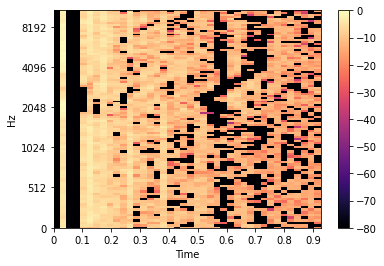

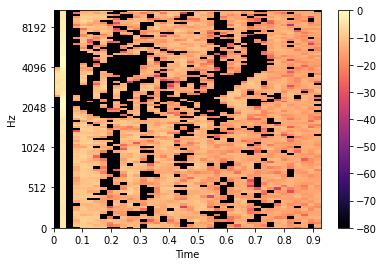

In [47]:
spec1_db = librosa.power_to_db(spec1, ref=np.max)[:,:,0]
plt.figure()
librosa.display.specshow(spec1_db, y_axis='mel', x_axis='time')
plt.colorbar()

spec2_db = librosa.power_to_db(spec2, ref=np.max)[:,:,0]
plt.figure()
librosa.display.specshow(spec2_db, y_axis='mel', x_axis='time')
plt.colorbar()

/home/phuc/.local/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/phuc/.local/lib/python3.6/site-packages/librosa/display.py:831: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


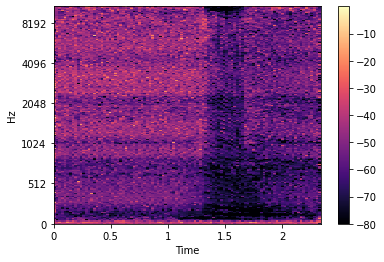

In [13]:
S_db = librosa.amplitude_to_db(spec1/spec2, ref=np.max)
plt.figure()
librosa.display.specshow(S_db, y_axis='mel', x_axis='time')
plt.colorbar()